# Resume-Job Description Fit Analysis
## OpenAI text-embedding-3-small + Cosine Similarity with Stratified Sampling

This notebook evaluates resume-job matching using OpenAI's text-embedding-3-small model with cosine similarity on a stratified sample (default size: 20 pairs).

**Workflow:**
1. Load dataset and create stratified sample
2. Generate embeddings using OpenAI text-embedding-3-small
3. Calculate cosine similarity scores for resume-job pairs
4. Tune thresholds to optimize F1-score
5. Generate predictions and calculate evaluation metrics

## 1. Import Required Libraries

Import necessary libraries for data handling, OpenAI API integration, and evaluation metrics.

In [39]:
import pandas as pd
import numpy as np
import re
import os
import subprocess
import sys
import time

# Install required libraries
print("Installing required libraries...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "openai"])
print("✓ Libraries installed successfully")

# ML and visualization libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# OpenAI library
from openai import OpenAI

print("✓ All imports completed successfully")

Installing required libraries...
✓ Libraries installed successfully
✓ All imports completed successfully


## 2. Load and Prepare Dataset

Load the training dataset and display basic information about the data structure and class distribution.

In [40]:
# Load the training dataset
#if os.path.exists('/content/drive/MyDrive'):
#    # Colab environment
#    csv_path = '/content/drive/MyDrive/AI-ML Self Learning/next_horizon/resume_job_recommendation/cnamuangtoun-resume-job-description-fit/train.csv'
#else:
#    # Local environment
#    csv_path = 'train.csv'
csv_path = 'train.csv'

df_train = pd.read_csv(csv_path)

print("="*80)
print("DATASET INFORMATION")
print("="*80)
print(f"\nDataset shape: {df_train.shape}")
print(f"\nColumn types:\n{df_train.dtypes}")
print(f"\nFirst few rows:")
print(df_train.head())

print(f"\n\nClass Distribution:")
print(df_train['label'].value_counts())
print(f"\nClass Distribution (%):")
print(df_train['label'].value_counts(normalize=True) * 100)

DATASET INFORMATION

Dataset shape: (6241, 3)

Column types:
resume_text             object
job_description_text    object
label                   object
dtype: object

First few rows:
                                         resume_text  \
0  SummaryHighly motivated Sales Associate with e...   
1  Professional SummaryCurrently working with Cat...   
2  SummaryI started my construction career in Jun...   
3  SummaryCertified Electrical Foremanwith thirte...   
4  SummaryWith extensive experience in business/r...   

                                job_description_text   label  
0  Net2Source Inc. is an award-winning total work...  No Fit  
1  At Salas OBrien we tell our clients that were ...  No Fit  
2  Schweitzer Engineering Laboratories (SEL) Infr...  No Fit  
3  Mizick Miller & Company, Inc. is looking for a...  No Fit  
4  Life at Capgemini\nCapgemini supports all aspe...  No Fit  


Class Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: 

## 3. Create Stratified Sample

Create a stratified random sample from the training dataset to maintain class distribution. Default sample size is 20 pairs.

In [41]:
# Configuration
SAMPLE_SIZE = 100  # Change this to adjust sample size

print("="*80)
print("CREATING STRATIFIED SAMPLE")
print("="*80)

# Get class counts and ratios
class_counts = df_train['label'].value_counts()
class_ratios = class_counts / len(df_train)

print(f"\nOriginal class distribution:")
for label, count in class_counts.items():
    pct = (count / len(df_train)) * 100
    print(f"  {label}: {count:5d} ({pct:5.1f}%)")

# Perform stratified sampling
df_sample = df_train.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max(1, int(SAMPLE_SIZE * class_ratios[x.name])), random_state=42)
).copy()

# Adjust if we didn't get exactly SAMPLE_SIZE
if len(df_sample) < SAMPLE_SIZE:
    remaining = SAMPLE_SIZE - len(df_sample)
    extra_samples = df_train.drop(df_sample.index).sample(n=remaining, random_state=42)
    df_sample = pd.concat([df_sample, extra_samples])
elif len(df_sample) > SAMPLE_SIZE:
    df_sample = df_sample.sample(n=SAMPLE_SIZE, random_state=42)

print(f"\nStratified sample ({len(df_sample)} pairs):")
sample_counts = df_sample['label'].value_counts()
for label in class_counts.index:
    count = sample_counts.get(label, 0)
    pct = (count / len(df_sample)) * 100 if len(df_sample) > 0 else 0
    print(f"  {label}: {count:5d} ({pct:5.1f}%)")

print(f"\n✓ Stratified sample created with {len(df_sample)} pairs")

CREATING STRATIFIED SAMPLE

Original class distribution:
  No Fit:  3143 ( 50.4%)
  Potential Fit:  1556 ( 24.9%)
  Good Fit:  1542 ( 24.7%)

Stratified sample (100 pairs):
  No Fit:    51 ( 51.0%)
  Potential Fit:    24 ( 24.0%)
  Good Fit:    25 ( 25.0%)

✓ Stratified sample created with 100 pairs


/tmp/ipython-input-1118149893.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_train.groupby('label', group_keys=False).apply(


## 4. Setup OpenAI API and Utility Functions

Configure OpenAI API key and define functions for text normalization and embedding generation.

In [42]:
print("="*80)
print("SETTING UP OPENAI API")
print("="*80 + "\n")

# Get API key from environment or prompt user
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    print("⚠️  OPENAI_API_KEY not found in environment variables.")
    print("Please set your OpenAI API key by:")
    print("  1. Creating an account at https://platform.openai.com")
    print("  2. Getting your API key from https://platform.openai.com/account/api-keys")
    print("  3. Setting the environment variable or entering it below\n")
    api_key = input("Enter your OpenAI API key: ").strip()
    if not api_key:
        raise ValueError("OpenAI API key is required to proceed.")

os.environ["OPENAI_API_KEY"] = api_key

# Define utility functions
def _cosine(a, b):
    """Calculate cosine similarity between two vectors"""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(a.dot(b) / (na * nb))

def _norm(s: str) -> str:
    """Normalize text string"""
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

def get_openai_embeddings(texts: list, batch_size: int = 50) -> list:
    """
    Generate embeddings for a list of texts using OpenAI's text-embedding-3-small model,
    processing in batches to avoid API token limits.
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OpenAI API key not found. Please set OPENAI_API_KEY environment variable.")

    client = OpenAI(api_key=api_key)
    model = "text-embedding-3-small"
    all_embeddings = []

    # Filter out None/empty texts and normalize
    normalized_texts = [_norm(str(t)) if t else "" for t in texts]

    for i in range(0, len(normalized_texts), batch_size):
        batch = normalized_texts[i : i + batch_size]
        # Filter out empty strings from batch, as OpenAI API might complain if an empty string is passed
        # and a list of texts can't be empty
        batch = [text for text in batch if text.strip() != ""]
        if not batch:
            continue # Skip if batch is empty

        try:
            response = client.embeddings.create(model=model, input=batch)
            embeddings = [np.array(emb.embedding) for emb in response.data]
            all_embeddings.extend(embeddings)
        except Exception as e:
            raise RuntimeError(f"OpenAI API error during batch {i//batch_size + 1}: {str(e)}. Please check your API key and connection.")

    return all_embeddings

print("✓ OpenAI API configured")
print("✓ Utility functions defined")

SETTING UP OPENAI API

✓ OpenAI API configured
✓ Utility functions defined


## 5. Generate Embeddings and Calculate Cosine Similarity

Generate embeddings for resume and job description texts using OpenAI API, then calculate cosine similarity scores.

In [43]:
%%time
print("="*80)
print("GENERATING EMBEDDINGS AND SIMILARITY SCORES")
print("="*80 + "\n")

# Get unique texts from sample
unique_resumes = df_sample['resume_text'].unique()
unique_jds = df_sample['job_description_text'].unique()

# Generate embeddings for unique resume texts
print(f"Generating embeddings for {len(unique_resumes)} unique resume texts...")
resume_embeddings_dict = {}

try:
    # Explicitly setting a smaller batch_size to avoid token limit errors
    resume_embeddings_list = get_openai_embeddings(list(unique_resumes), batch_size=5)
    for resume, embedding in zip(unique_resumes, resume_embeddings_list):
        resume_embeddings_dict[resume] = embedding
    print(f"✓ Generated embeddings for {len(resume_embeddings_dict)} unique resumes")
    print(f"  Embedding dimension: {len(resume_embeddings_list[0])}")
except Exception as e:
    print(f"✗ Error generating resume embeddings: {e}")
    raise

# Generate embeddings for unique job description texts
print(f"\nGenerating embeddings for {len(unique_jds)} unique job description texts...")
jd_embeddings_dict = {}

try:
    # Explicitly setting a smaller batch_size to avoid token limit errors
    jd_embeddings_list = get_openai_embeddings(list(unique_jds), batch_size=5)
    for jd, embedding in zip(unique_jds, jd_embeddings_list):
        jd_embeddings_dict[jd] = embedding
    print(f"✓ Generated embeddings for {len(jd_embeddings_dict)} unique job descriptions")
    print(f"  Embedding dimension: {len(jd_embeddings_list[0])}")
except Exception as e:
    print(f"✗ Error generating job description embeddings: {e}")
    raise

# Compute cosine similarities for each resume-JD pair
print(f"\nComputing cosine similarity scores for {len(df_sample)} pairs...")
df_sample['cosine_similarity'] = df_sample.apply(
    lambda row: _cosine(
        resume_embeddings_dict[row['resume_text']],
        jd_embeddings_dict[row['job_description_text']]
    ),
    axis=1
)

print(f"✓ Computed similarity scores for {len(df_sample)} records")
print(f"\n{'='*80}")
print("SIMILARITY SCORE STATISTICS")
print(f"{'='*80}")
print(f"  Min:    {df_sample['cosine_similarity'].min():.4f}")
print(f"  Q1:     {df_sample['cosine_similarity'].quantile(0.25):.4f}")
print(f"  Mean:   {df_sample['cosine_similarity'].mean():.4f}")
print(f"  Median: {df_sample['cosine_similarity'].median():.4f}")
print(f"  Q3:     {df_sample['cosine_similarity'].quantile(0.75):.4f}")
print(f"  Max:    {df_sample['cosine_similarity'].max():.4f}")
print(f"  Std:    {df_sample['cosine_similarity'].std():.4f}")

# Show distribution by label
print(f"\n{'='*80}")
print("SIMILARITY SCORE DISTRIBUTION BY ACTUAL LABEL")
print(f"{'='*80}")

for label in ['No Fit', 'Potential Fit', 'Good Fit']:
    label_scores = df_sample[df_sample['label'] == label]['cosine_similarity']
    if len(label_scores) > 0:
        print(f"\n{label} (n={len(label_scores)}):")
        print(f"  Mean:   {label_scores.mean():.4f}")
        print(f"  Median: {label_scores.median():.4f}")
        print(f"  Std:    {label_scores.std():.4f}")
        print(f"  Min:    {label_scores.min():.4f}")
        print(f"  Max:    {label_scores.max():.4f}")

GENERATING EMBEDDINGS AND SIMILARITY SCORES

Generating embeddings for 86 unique resume texts...
✓ Generated embeddings for 86 unique resumes
  Embedding dimension: 1536

Generating embeddings for 79 unique job description texts...
✓ Generated embeddings for 79 unique job descriptions
  Embedding dimension: 1536

Computing cosine similarity scores for 100 pairs...
✓ Computed similarity scores for 100 records

SIMILARITY SCORE STATISTICS
  Min:    0.3304
  Q1:     0.4207
  Mean:   0.4784
  Median: 0.4783
  Q3:     0.5201
  Max:    0.6523
  Std:    0.0688

SIMILARITY SCORE DISTRIBUTION BY ACTUAL LABEL

No Fit (n=51):
  Mean:   0.4481
  Median: 0.4433
  Std:    0.0545
  Min:    0.3304
  Max:    0.5855

Potential Fit (n=24):
  Mean:   0.5153
  Median: 0.5135
  Std:    0.0638
  Min:    0.4123
  Max:    0.6304

Good Fit (n=25):
  Mean:   0.5049
  Median: 0.5123
  Std:    0.0735
  Min:    0.3442
  Max:    0.6523
CPU times: user 341 ms, sys: 15.8 ms, total: 357 ms
Wall time: 14.5 s


## 6. Threshold Tuning

Test multiple threshold combinations to find optimal low and high thresholds that maximize F1-score.

In [44]:
def predict_fit_label(similarity_score, threshold_low=0.50, threshold_high=0.65):
    """
    Predict fit label based on cosine similarity score and thresholds

    - score < threshold_low: "No Fit"
    - threshold_low <= score < threshold_high: "Potential Fit"
    - score >= threshold_high: "Good Fit"
    """
    if similarity_score < threshold_low:
        return "No Fit"
    elif similarity_score < threshold_high:
        return "Potential Fit"
    else:
        return "Good Fit"

print("="*80)
print("THRESHOLD TUNING")
print("="*80 + "\n")

results_tuning = []

# Test different threshold combinations
print("Testing threshold combinations...")
for low_threshold in [0.40, 0.45, 0.50, 0.55, 0.60]:
    for high_threshold in [low_threshold + 0.10, low_threshold + 0.15, low_threshold + 0.20]:
        # Predict with current thresholds
        predictions = df_sample['cosine_similarity'].apply(
            lambda x: predict_fit_label(x, threshold_low=low_threshold, threshold_high=high_threshold)
        )

        # Calculate metrics
        acc = accuracy_score(df_sample['label'], predictions)
        prec = precision_score(df_sample['label'], predictions, average='macro', zero_division=0)
        rec = recall_score(df_sample['label'], predictions, average='macro', zero_division=0)
        f1 = f1_score(df_sample['label'], predictions, average='macro', zero_division=0)

        results_tuning.append({
            'Low_Threshold': low_threshold,
            'High_Threshold': high_threshold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Score': f1
        })

tuning_df = pd.DataFrame(results_tuning)
tuning_df = tuning_df.sort_values('F1_Score', ascending=False)

print(f"\nTop 10 Threshold Combinations (by F1-Score):")
print(tuning_df.head(10).to_string(index=False))

# Get best thresholds
best_row = tuning_df.iloc[0]
print(f"\n{'='*80}")
print("✓ BEST THRESHOLDS FOUND")
print(f"{'='*80}")
print(f"  Low Threshold:  {best_row['Low_Threshold']:.2f}")
print(f"  High Threshold: {best_row['High_Threshold']:.2f}")
print(f"  Accuracy:       {best_row['Accuracy']:.4f}")
print(f"  Precision:      {best_row['Precision']:.4f}")
print(f"  Recall:         {best_row['Recall']:.4f}")
print(f"  F1-Score:       {best_row['F1_Score']:.4f}")

THRESHOLD TUNING

Testing threshold combinations...

Top 10 Threshold Combinations (by F1-Score):
 Low_Threshold  High_Threshold  Accuracy  Precision   Recall  F1_Score
          0.45            0.55      0.49   0.494422 0.463431  0.454859
          0.50            0.60      0.56   0.512097 0.474641  0.449261
          0.50            0.65      0.57   0.688899 0.489641  0.431463
          0.45            0.60      0.49   0.522243 0.465654  0.423411
          0.50            0.70      0.56   0.352009 0.476307  0.403178
          0.45            0.65      0.50   0.697009 0.480654  0.399732
          0.55            0.65      0.57   0.683333 0.430817  0.387274
          0.55            0.75      0.56   0.340278 0.417484  0.358642
          0.55            0.70      0.56   0.340278 0.417484  0.358642
          0.40            0.55      0.34   0.502315 0.394804  0.337697

✓ BEST THRESHOLDS FOUND
  Low Threshold:  0.45
  High Threshold: 0.55
  Accuracy:       0.4900
  Precision:      0.4944


## 7. Generate Predictions with Optimized Thresholds

Apply the optimized thresholds to convert similarity scores into predicted fit labels.

In [45]:
# Apply optimized thresholds
best_low = best_row['Low_Threshold']
best_high = best_row['High_Threshold']

print("="*80)
print("GENERATING PREDICTIONS WITH OPTIMIZED THRESHOLDS")
print("="*80 + "\n")

df_sample['predicted_label'] = df_sample['cosine_similarity'].apply(
    lambda x: predict_fit_label(x, threshold_low=best_low, threshold_high=best_high)
)

print(f"Optimized Thresholds: Low={best_low:.2f}, High={best_high:.2f}\n")
print(f"Predicted Label Distribution:")
print(df_sample['predicted_label'].value_counts())
print(f"\nActual Label Distribution:")
print(df_sample['label'].value_counts())

# Show sample predictions
print(f"\n{'='*80}")
print("SAMPLE PREDICTIONS (First 10 rows)")
print(f"{'='*80}")
sample_display = df_sample[['resume_text', 'job_description_text', 'cosine_similarity',
                             'label', 'predicted_label']].head(10).copy()
sample_display['resume_text'] = sample_display['resume_text'].str[:40] + '...'
sample_display['job_description_text'] = sample_display['job_description_text'].str[:40] + '...'
print(sample_display.to_string(index=False))

GENERATING PREDICTIONS WITH OPTIMIZED THRESHOLDS

Optimized Thresholds: Low=0.45, High=0.55

Predicted Label Distribution:
predicted_label
Potential Fit    46
No Fit           38
Good Fit         16
Name: count, dtype: int64

Actual Label Distribution:
label
No Fit           51
Good Fit         25
Potential Fit    24
Name: count, dtype: int64

SAMPLE PREDICTIONS (First 10 rows)
                                resume_text                         job_description_text  cosine_similarity    label predicted_label
ProfileSecure a position with a well-est...  Hello, please look into the below mentio...           0.652291 Good Fit        Good Fit
Professional SummaryTransportation Logis...  Role - Business Analyst - Mobile Locatio...           0.493195 Good Fit   Potential Fit
Professional SummaryJr. Data Analyst wit...  Hello,Greetings from DevCare SolutionsI ...           0.513232 Good Fit   Potential Fit
SummaryElectronics technician and hardwa...  Our client is a growing Medical Device c..

## 8. Calculate Evaluation Metrics

Calculate accuracy, precision, recall, F1-score, and generate a confusion matrix and classification report.

In [46]:
print("="*80)
print("EVALUATION METRICS")
print("="*80 + "\n")

# Calculate metrics
accuracy = accuracy_score(df_sample['label'], df_sample['predicted_label'])
precision_macro = precision_score(df_sample['label'], df_sample['predicted_label'], average='macro', zero_division=0)
precision_weighted = precision_score(df_sample['label'], df_sample['predicted_label'], average='weighted', zero_division=0)
recall_macro = recall_score(df_sample['label'], df_sample['predicted_label'], average='macro', zero_division=0)
recall_weighted = recall_score(df_sample['label'], df_sample['predicted_label'], average='weighted', zero_division=0)
f1_macro = f1_score(df_sample['label'], df_sample['predicted_label'], average='macro', zero_division=0)
f1_weighted = f1_score(df_sample['label'], df_sample['predicted_label'], average='weighted', zero_division=0)

print(f"Accuracy:                {accuracy:.4f}")
print(f"Precision (Macro Avg):   {precision_macro:.4f}")
print(f"Precision (Weighted Avg):{precision_weighted:.4f}")
print(f"Recall (Macro Avg):      {recall_macro:.4f}")
print(f"Recall (Weighted Avg):   {recall_weighted:.4f}")
print(f"F1-Score (Macro Avg):    {f1_macro:.4f}")
print(f"F1-Score (Weighted Avg): {f1_weighted:.4f}")

print(f"\n{'='*80}")
print("CLASSIFICATION REPORT")
print(f"{'='*80}\n")
print(classification_report(df_sample['label'], df_sample['predicted_label'], zero_division=0))

# Confusion Matrix
print(f"\n{'='*80}")
print("CONFUSION MATRIX")
print(f"{'='*80}\n")
labels_list = ['No Fit', 'Potential Fit', 'Good Fit']
cm = confusion_matrix(df_sample['label'], df_sample['predicted_label'], labels=labels_list)
cm_df = pd.DataFrame(cm, index=labels_list, columns=labels_list)
print("Rows: Actual | Columns: Predicted\n")
print(cm_df)

EVALUATION METRICS

Accuracy:                0.4900
Precision (Macro Avg):   0.4944
Precision (Weighted Avg):0.5664
Recall (Macro Avg):      0.4634
Recall (Weighted Avg):   0.4900
F1-Score (Macro Avg):    0.4549
F1-Score (Weighted Avg): 0.5069

CLASSIFICATION REPORT

               precision    recall  f1-score   support

     Good Fit       0.44      0.28      0.34        25
       No Fit       0.76      0.57      0.65        51
Potential Fit       0.28      0.54      0.37        24

     accuracy                           0.49       100
    macro avg       0.49      0.46      0.45       100
 weighted avg       0.57      0.49      0.51       100


CONFUSION MATRIX

Rows: Actual | Columns: Predicted

               No Fit  Potential Fit  Good Fit
No Fit             29             20         2
Potential Fit       4             13         7
Good Fit            5             13         7


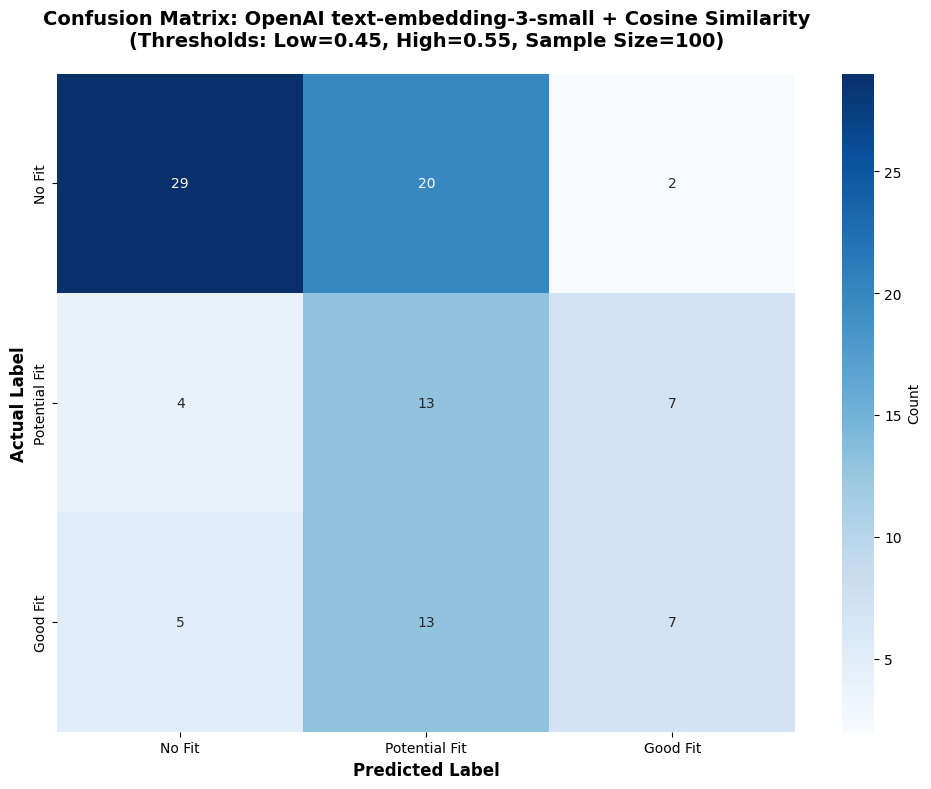

✓ Confusion matrix visualization displayed.


In [47]:
# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title('Confusion Matrix: OpenAI text-embedding-3-small + Cosine Similarity\n' +
             f'(Thresholds: Low={best_low:.2f}, High={best_high:.2f}, Sample Size={len(df_sample)})',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Actual Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Confusion matrix visualization displayed.")

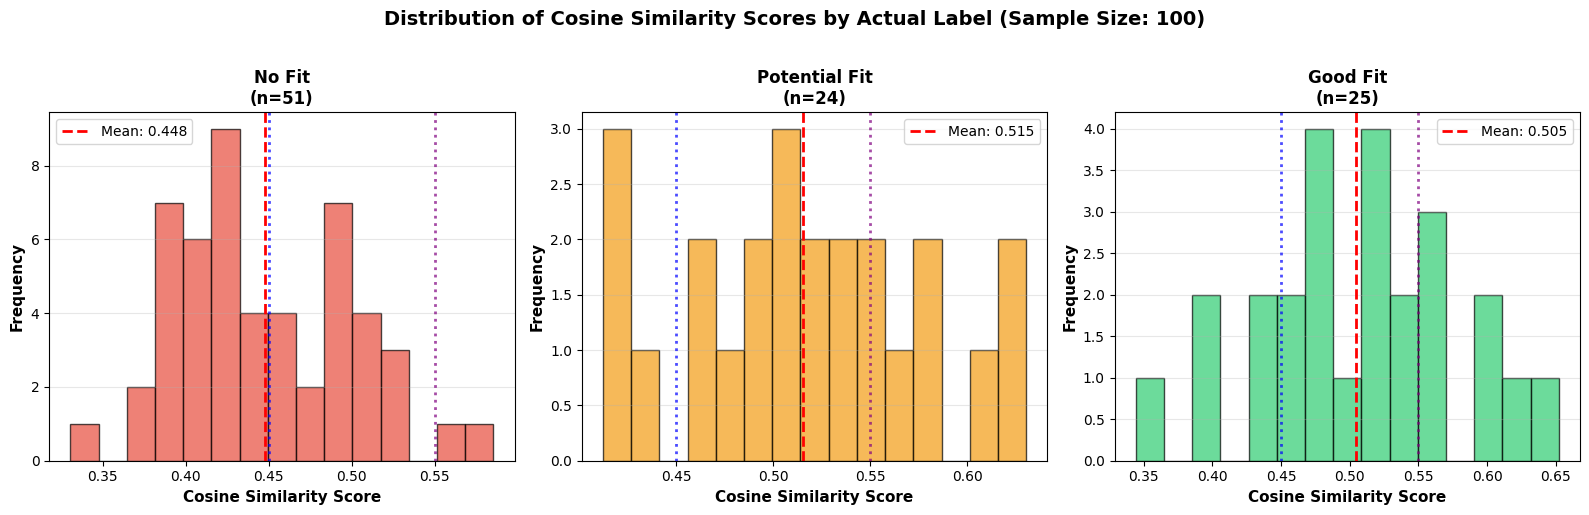

✓ Similarity score distribution visualization displayed.


In [48]:
# Visualize similarity score distribution by actual label
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

labels_list = ['No Fit', 'Potential Fit', 'Good Fit']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

for ax, label, color in zip(axes, labels_list, colors):
    label_scores = df_sample[df_sample['label'] == label]['cosine_similarity']
    if len(label_scores) > 0:
        ax.hist(label_scores, bins=15, color=color, alpha=0.7, edgecolor='black')
        ax.axvline(label_scores.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {label_scores.mean():.3f}')
        ax.set_xlabel('Cosine Similarity Score', fontsize=11, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f'{label}\n(n={len(label_scores)})', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

# Add threshold lines
for ax in axes:
    ax.axvline(best_low, color='blue', linestyle=':', linewidth=2, alpha=0.7, label='Low Threshold')
    ax.axvline(best_high, color='purple', linestyle=':', linewidth=2, alpha=0.7, label='High Threshold')

plt.suptitle(f'Distribution of Cosine Similarity Scores by Actual Label (Sample Size: {len(df_sample)})',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Similarity score distribution visualization displayed.")

In [49]:
# Summary and results
print("\n" + "="*80)
print("SUMMARY AND RESULTS")
print("="*80 + "\n")

print(f"STRATIFIED SAMPLE SIZE: {len(df_sample)} pairs")
print(f"\nOPTIMIZED THRESHOLDS:")
print(f"  Low Threshold:  {best_low:.2f}")
print(f"  High Threshold: {best_high:.2f}")

print(f"\nFINAL PERFORMANCE METRICS:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision_macro:.4f} (macro-averaged)")
print(f"  Recall:    {recall_macro:.4f} (macro-averaged)")
print(f"  F1-Score:  {f1_macro:.4f} (macro-averaged)")

if f1_macro > 0.50:
    print(f"\n✓ GOOD PERFORMANCE - F1-Score > 0.50")
elif f1_macro > 0.30:
    print(f"\n⚠ MODERATE PERFORMANCE - F1-Score > 0.30")
else:
    print(f"\n✗ NEEDS IMPROVEMENT - F1-Score < 0.30")

print(f"\nMODEL: OpenAI text-embedding-3-small + Cosine Similarity")
print(f"DATASET: Resume-Job Description Matching")
print(f"EVALUATION: Stratified sampling with class distribution maintained")

print("\n" + "="*80)


SUMMARY AND RESULTS

STRATIFIED SAMPLE SIZE: 100 pairs

OPTIMIZED THRESHOLDS:
  Low Threshold:  0.45
  High Threshold: 0.55

FINAL PERFORMANCE METRICS:
  Accuracy:  0.4900
  Precision: 0.4944 (macro-averaged)
  Recall:    0.4634 (macro-averaged)
  F1-Score:  0.4549 (macro-averaged)

⚠ MODERATE PERFORMANCE - F1-Score > 0.30

MODEL: OpenAI text-embedding-3-small + Cosine Similarity
DATASET: Resume-Job Description Matching
EVALUATION: Stratified sampling with class distribution maintained

